# model 탐색 / 방안1: autogluon .. 성능지표 좋은 모델 탐색, 파인튜닝. "성능"보다도 "설명 가능성"
# model 탐색 / 방안2: 로지스틱 회귀 등 "feature" 중요성 나타낼 수 있는 분석 탐색, "xgboost-feature importance, shap value" (현 문서)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 26)

df= pd.read_csv('kidney_disease_4.csv') #결측치 처리 완료한 데이터셋
df['class'] = 1 - df['class'] #class 1: CKD, class 0: non-CKD (원래 0을 1로 바꿔줌)

In [2]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']


In [3]:
from matplotlib import style
style.use("default")


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


scaler = StandardScaler()

numeric_features = df.select_dtypes(include='float64').columns
binary_features = df.select_dtypes(include='int64').drop('class', axis=1).columns

#범주형과 이진형 변수 스케일링 다르게 처리
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough', binary_features),
])

#기존에 범주형 변수는 label encoding 했음. 
#one hot encoding 사용하지 않았음.

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# GAM 구현을 위한 EBM (interpret 패키지 필요: pip install interpret)
from interpret.glassbox import ExplainableBoostingClassifier
import shap
from sklearn.calibration import (
    CalibratedClassifierCV, calibration_curve
)
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    brier_score_loss
)
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, 
    confusion_matrix, RocCurveDisplay
)
from xgboost import XGBClassifier
from sklearn.svm import SVC
import shap
import matplotlib.pyplot as plt

In [6]:
# 1) 데이터 분할
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 2) 전처리 정의
numeric_features = X.select_dtypes(include='float64').columns.tolist()
binary_features  = X.select_dtypes(include='int64').columns.tolist()


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough',    binary_features),
])


In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression
#1. 로지스틱 회귀
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        penalty='l2', solver='liblinear',
        random_state=42, max_iter=1000
    ))
])

# 1-1) 교차검증
scores = cross_val_score(
    pipe_lr, X, y,
    cv=cv, scoring='roc_auc'
)
print(f"LogisticRegression CV ROC‑AUC: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

# 1-2) train/test 분할 후 평가
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=42
)
pipe_lr.fit(X_train, y_train)
y_pred  = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]

print("\n[LogisticRegression] Test Set")
print(classification_report(y_test, y_pred))
print("ROC‑AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

LogisticRegression CV ROC‑AUC: 0.998 ± 0.002

[LogisticRegression] Test Set
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.98      0.94      0.96        50

    accuracy                           0.95        80
   macro avg       0.94      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

ROC‑AUC: 0.9966666666666667
Confusion Matrix:
 [[29  1]
 [ 3 47]]


In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

pipe_dt = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(
        max_depth=4, random_state=42
    ))
])

# 2-1) 교차검증
scores = cross_val_score(
    pipe_dt, X, y,
    cv=cv, scoring='roc_auc'
)
print(f"DecisionTree (depth=4) CV ROC‑AUC: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

# 2-2) train/test 평가
pipe_dt.fit(X_train, y_train)
y_pred  = pipe_dt.predict(X_test)
y_proba = pipe_dt.predict_proba(X_test)[:,1]

print("\n[DecisionTree] Test Set")
print(classification_report(y_test, y_pred))
print("ROC‑AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

DecisionTree (depth=4) CV ROC‑AUC: 0.952 ± 0.008

[DecisionTree] Test Set
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.98      0.94      0.96        50

    accuracy                           0.95        80
   macro avg       0.94      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

ROC‑AUC: 0.9533333333333334
Confusion Matrix:
 [[29  1]
 [ 3 47]]


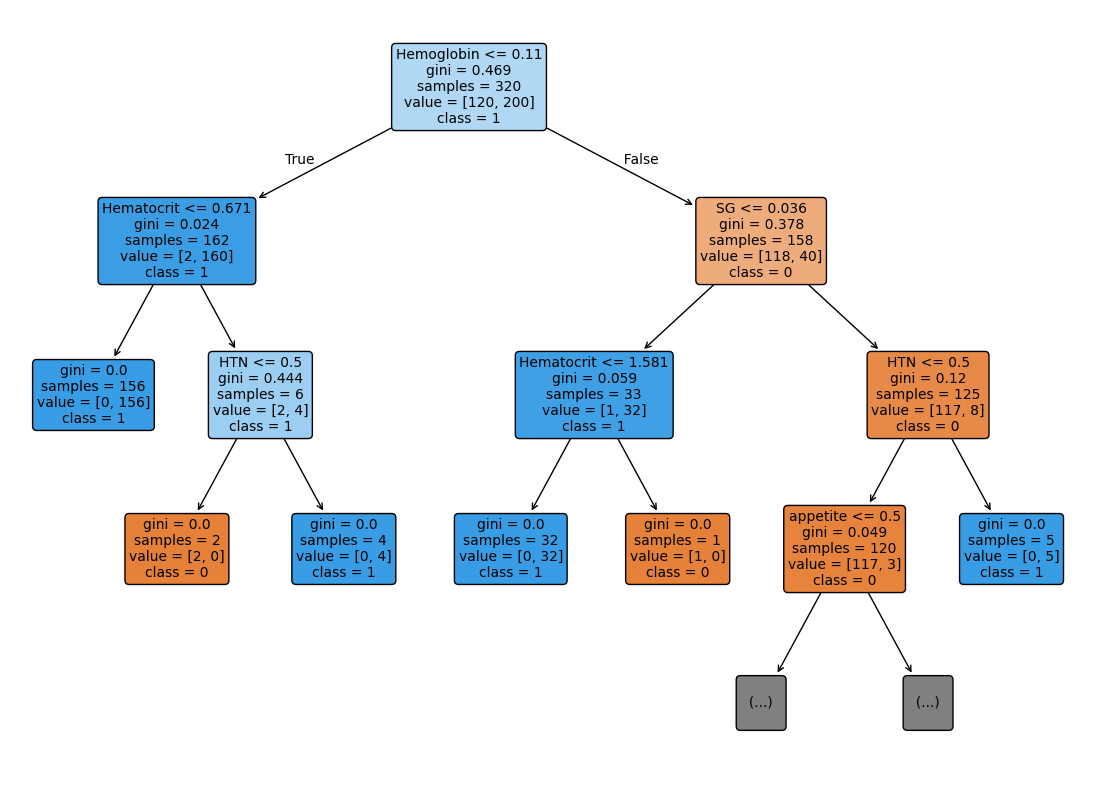

In [13]:
# 트리 시각화
plt.figure(figsize=(14,10))
plot_tree(
    pipe_dt.named_steps['clf'],
    feature_names = numeric_features + binary_features,
    class_names   = ['0','1'],
    filled        = True,
    rounded       = True,
    max_depth     = 3,
    fontsize      = 10
)
plt.show()

In [14]:
from xgboost import XGBClassifier
import shap

pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# 4-1) 교차검증
scores = cross_val_score(
    pipe_xgb, X, y,
    cv=cv, scoring='roc_auc'
)
print(f"XGBoost CV ROC‑AUC: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

# 4-2) train/test 평가
pipe_xgb.fit(X_train, y_train)
y_pred  = pipe_xgb.predict(X_test)
y_proba = pipe_xgb.predict_proba(X_test)[:,1]

print("\n[XGBoost] Test Set")
print(classification_report(y_test, y_pred))
print("ROC‑AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

XGBoost CV ROC‑AUC: 0.998 ± 0.002

[XGBoost] Test Set
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.98      0.96      0.97        50

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

ROC‑AUC: 0.9966666666666667
Confusion Matrix:
 [[29  1]
 [ 2 48]]


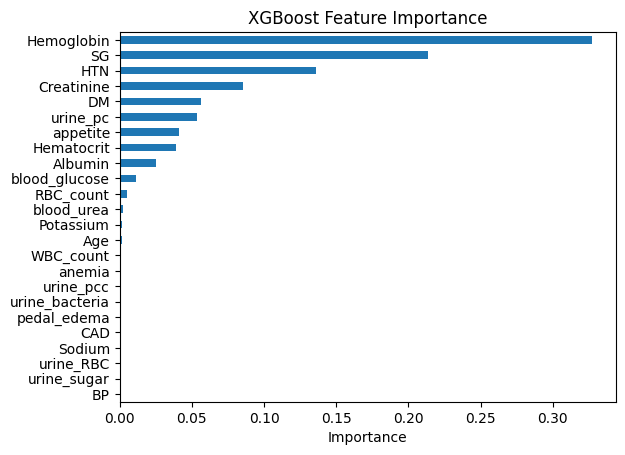

In [16]:
# Feature Importance
fi = pd.Series(
    pipe_xgb.named_steps['clf'].feature_importances_,
    index = numeric_features + binary_features
).sort_values(ascending=True)
fi.plot.barh(title="XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

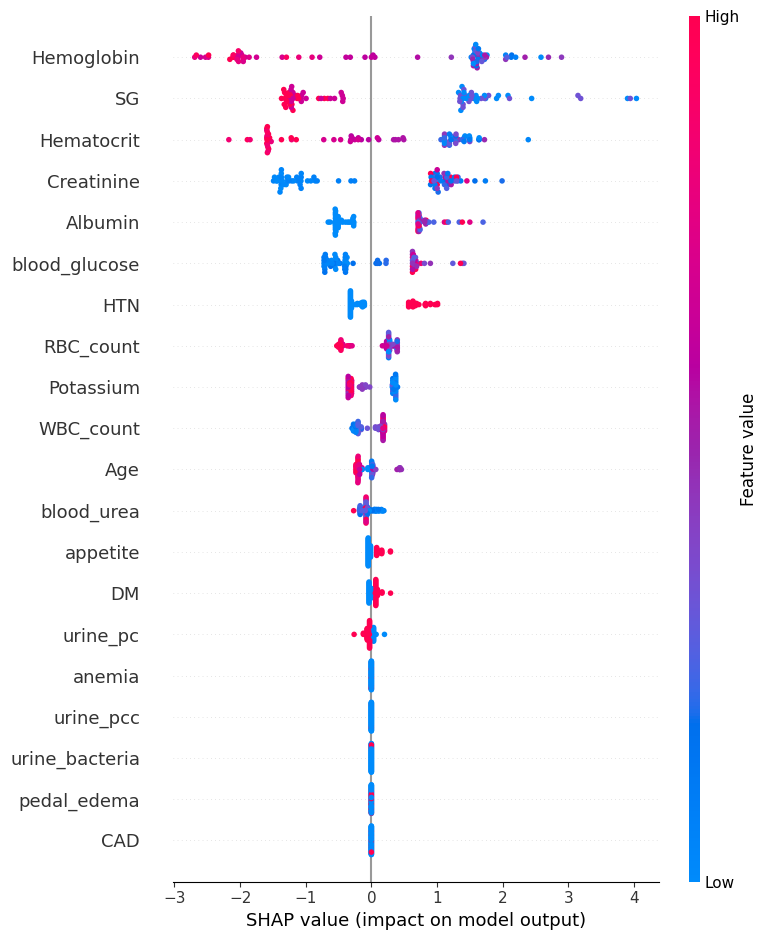

In [18]:
X_test_scaled = pipe_xgb.named_steps['pre'].transform(X_test)
explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(
    shap_values, X_test_scaled,
    feature_names = numeric_features + binary_features
)

In [21]:
from sklearn.metrics import accuracy_score, f1_score

results = []
for name, (y_pred, y_proba) in [
    ('LogisticRegression', (y_pred_lr,  y_proba_lr)),
    ('DecisionTree',        (y_pred_dt,  y_proba_dt)),
    ('XGBoost',             (y_pred_xgb, y_proba_xgb))
]:
    results.append({
        'Model'    : name,
        'Accuracy' : accuracy_score(y_test, y_pred),
        'F1‑Score' : f1_score(y_test, y_pred),
        'ROC‑AUC'  : roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(results).set_index('Model')
print("\n=== Performance Comparison ===")
print(metrics_df)


=== Performance Comparison ===
                    Accuracy  F1‑Score   ROC‑AUC
Model                                           
LogisticRegression    0.9500  0.959184  0.996667
DecisionTree          0.9500  0.959184  0.953333
XGBoost               0.9625  0.969697  0.996667
